In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import scipy
import matplotlib as mpl
import sympy as sp
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha
import ROOT
import xml.etree.ElementTree as ET


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


In [2]:
MU = 0.00255
MC = 1.27
MT = 172
MD = 0.00504
MS = 0.101
MB = 4.7
MZp = np.array([500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 
       1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2200.0, 2300.0, 2400.0, 2500.0, 2600.0, 
       2700.0, 2800.0, 2900.0, 3000.0])
Mchi = 65.0
# gq = np.array([0.01, 0.1, 0.2, 0.25])
gq = 0.25
# gchi = np.array([0.1, 0.5, 1.0, 2.0])
gchi = 1.0
gqA = 0.0
gZp = 1.0
# gqV = np.array([0.01, 0.1, 0.2, 0.25])
gqV = 0.25
gqA = 0.0
gqL = gqV 
gqR = gqV 

# zpuu = ((-48*gqA**2*MU**2 + 48*gqA*gqL*gZp*MU**2 - 48*gqA*gqR*gZp*MU**2 
#            - 6*gqL**2*gZp**2*MU**2 + 36*gqL*gqR*gZp**2*MU**2 - 6*gqR**2*gZp**2*MU**2 
#            + 12*gqA**2*MZp**2 - 12*gqA*gqL*gZp*MZp**2 + 12*gqA*gqR*gZp*MZp**2 + 6*gqL**2*gZp**2*MZp**2 
#            + 6*gqR**2*gZp**2*MZp**2)*np.sqrt(-4*MU**2*MZp**2 + MZp**4))/(48*np.pi*abs(MZp)**3)

zpcc = ((-48*gqA**2*MC**2 + 24*gq**2*gZp**2*MC**2 + 12*gqA**2*MZp**2 
           + 12*gq**2*gZp**2*MZp**2)*np.sqrt(-4*MC**2*MZp**2 + MZp**4))/(48*np.pi*abs(MZp)**3)
            
zptt = ((-48*gqA**2*MT**2 + 24*gq**2*gZp**2*MT**2 + 12*gqA**2*MZp**2 
            + 12*gq**2*gZp**2*MZp**2)*np.sqrt(-4*MT**2*MZp**2 + MZp**4))/(48*np.pi*abs(MZp)**3)
                      
zpdd = ((-48*gqA**2*MD**2 + 24*gq**2*gZp**2*MD**2 + 12*gqA**2*MZp**2 
            + 12*gq**2*gZp**2*MZp**2)*np.sqrt(-4*MD**2*MZp**2 + MZp**4))/(48*np.pi*abs(MZp)**3)
                        
zpss = ((-48*gqA**2*MS**2 + 24*gq**2*gZp**2*MS**2 + 12*gqA**2*MZp**2 
            + 12*gq**2*gZp**2*MZp**2)*np.sqrt(-4*MS**2*MZp**2 + MZp**4))/(48*np.pi*abs(MZp)**3)
                        
zpbb = ((-48*gqA**2*MB**2 + 24*gq**2*gZp**2*MB**2 + 12*gqA**2*MZp**2 
            + 12*gq**2*gZp**2*MZp**2)*np.sqrt(-4*MB**2*MZp**2 + MZp**4))/(48*np.pi*abs(MZp)**3)
                        

zpchichi = ((-16*gchi**2*Mchi**2 + 4*gchi**2*MZp**2)*np.sqrt(-4*Mchi**2*MZp**2 
                                                                + MZp**4))/(96*np.pi*abs(MZp)**3)
                        

GammaChi = zpchichi/(zpcc + zptt + zpdd + zpss + zpbb + zpchichi)


In [13]:
GammaChi

array([0.32896306, 0.33370267, 0.33705151, 0.3393918 , 0.34106567,
       0.3422958 , 0.34322295, 0.34393758, 0.34449927, 0.34494837,
       0.34531286, 0.3456126 , 0.34586199, 0.34607166, 0.34624958,
       0.34640183, 0.34653311, 0.34664708, 0.34674666, 0.34683417,
       0.34691147, 0.34698009, 0.34704128, 0.34709607, 0.34714533,
       0.34718977])

In [4]:
# Get data from MG5 runs
pclFiles = {'pp->zp': '../data/2mdm_zp_jet.pcl'}

df = [pd.read_pickle(f) for l, f in pclFiles.items()]
for d in df:
    d = d.sort_values(['$m_{med}$', '$\sin\\theta$', '$g_{q}$'],inplace=True, 
                     ascending=[True, True, True])

In [5]:
data = pd.DataFrame()
for d in df:
    data = pd.concat((data,d))

In [6]:
# Filter model

modelFilter = {
#                '$g_{q}$' : 0.1,
               '$g_{\chi}$': 1.0,
               '$\sin\\theta$': 0.1
               }

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in modelFilter.items()])
dfModel = data.loc[(data[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
textstr2 = '\n$g_{q}$ = 0.1'
textstr = textstr+textstr2

In [7]:
dfModel = dfModel[(dfModel['$g_{q}$'] == 0.25) | (dfModel['$g_{q}$'] == 1.0)]
dfModel = dfModel.drop(columns=['$m_{s}$', '$m_{\chi}$'])

In [11]:
dfModel

,process,$m_{med}$,$\Gamma_{zp}$,$\Gamma_{s}$,$g_{\chi}$,$g_{q}$,$\sin\theta$,Events,x-sec (pb),x-sec pT-250 (pb)
3,pp->zp,500.0,16.55137,0.605355,1.0,0.25,0.1,10000,149.178546,4.541841
7,pp->zp,600.0,20.52028,0.563825,1.0,0.25,0.1,10000,80.771551,3.381662
16,pp->zp,700.0,24.37958,0.542552,1.0,0.25,0.1,10000,47.412207,2.200025
20,pp->zp,800.0,28.17955,0.530814,1.0,0.25,0.1,10000,29.062503,1.364081
24,pp->zp,900.0,31.94278,0.52403,1.0,0.25,0.1,10000,18.675068,1.024292
28,pp->zp,1000.0,35.68142,0.520009,1.0,0.25,0.1,10000,12.343738,0.664348
32,pp->zp,1100.0,39.40266,0.517614,1.0,0.25,0.1,10000,8.436763,0.448494
36,pp->zp,1200.0,43.11111,0.516213,1.0,0.25,0.1,10000,5.856695,0.390682
40,pp->zp,1300.0,46.80985,0.515441,1.0,0.25,0.1,10000,4.138182,0.293061
44,pp->zp,1400.0,50.50106,0.515072,1.0,0.25,0.1,10000,2.984887,0.217667


In [9]:
colors = {label : sns.color_palette('deep', n_colors=16)[i] for i,label in enumerate(pclFiles.keys())}    

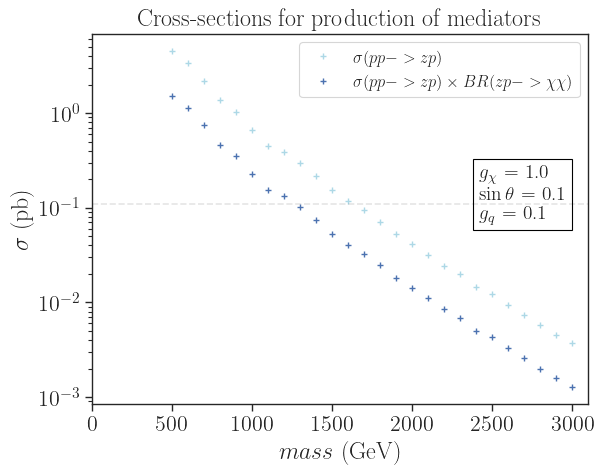

In [22]:
# plot cross-section

for label in pclFiles.keys():
    mass = np.array(dfModel['$m_{med}$'][dfModel['process'] == label])
    xsecs = np.array(dfModel['x-sec pT-250 (pb)'][dfModel['process'] == label])
    xsecsBR = xsecs*GammaChi
    plt.plot(mass, xsecs, color='lightblue', marker='+', linestyle='', label=r'$\sigma(%s)$' %(label))
    plt.plot(mass, xsecsBR, color=colors[label], marker='+', linestyle='', 
             label=r'$\sigma(%s) \times BR(zp -> \chi \chi)$' %(label))

    
plt.hlines(0.11, xmin=0.0, xmax=3100, linestyles='--', alpha=0.2, color='gray')
plt.yscale('log')

plt.title('Cross-sections for production of mediators')
plt.xlabel(r'$mass$ (GeV)')
plt.ylabel(r'$\sigma$ (pb)')

plt.text(0.78,0.5,textstr,fontsize=14,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
plt.xlim(0.0, 3100)

plt.legend(fontsize=12)
plt.show()